<h1 align="center">CPSC 4830</h1>
<h2 align="center">MIDTERM 1</h2>

# Question 1
The SMS Spam Collection is a set of SMS tagged messages that have been collected from SMS Spam research database. It contains one set of SMS messages in English of 5,572 messages, tagged acording being ham (legitimate) or spam.

Out of the 5572 sets of sms messages, approximately 20% of the messages have been trimmed and kept aside for Evaluating your model. You only have 4458 rows to build your model.

Use this dataset to build a prediction model as follows that will accurately classify which texts are spam.

1. Use Count vectorizer to convert the texts into numerical values.
2. Use Logistic Regression with L2 Regularisation, find the accuracy of SPAM/HAM detection.
3. Compare your result with Random Forest Classifier for this same dataset.



#### Exploratory Data Analysis

In [3]:
import pandas as pd
import numpy as np

In [4]:
spam_df = pd.read_csv("spamhamtrain.csv")

In [5]:
spam_df

,Category,Message
0,ham,"K I'm leaving soon, be there a little after 9"
1,ham,No. Yes please. Been swimming?
2,ham,It took Mr owl 3 licks
3,ham,Its going good...no problem..but still need li...
4,ham,K.. I yan jiu liao... Sat we can go 4 bugis vi...
...,...,...
4452,ham,K:)k:)good:)study well.
4453,ham,"Chinatown got porridge, claypot rice, yam cake..."
4454,ham,"Hmm... Dunno leh, mayb a bag 4 goigng out dat ..."
4455,ham,Tell me whos this pls:-)


In [6]:
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4457 entries, 0 to 4456
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  4457 non-null   object
 1   Message   4457 non-null   object
dtypes: object(2)
memory usage: 69.8+ KB


In [7]:
spam_df.describe()

,Category,Message
count,4457,4457
unique,2,4157
top,ham,"Sorry, I'll call later"
freq,3863,26


In [8]:
print('Ham comprises', round((3863/4457*100),2),'% of the dataset.')
print('Spam comprises', round((594/4457*100),2),'% of the dataset.')

Ham comprises 86.67 % of the dataset.
Spam comprises 13.33 % of the dataset.


In [9]:
spam_df['Category'].value_counts()

ham     3863
spam     594
Name: Category, dtype: int64

In [10]:
spam_df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         3863   3635                             Sorry, I'll call later   
spam         594    522  Please call our customer service representativ...   

               
         freq  
Category       
ham        26  
spam        4

In [11]:
# visualizing some of the repeated spam messages.
filter = spam_df[spam_df['Category'] == 'spam']
filter[filter.duplicated()].sort_values('Message')

,Category,Message
4377,spam,#ERROR!
2223,spam,#ERROR!
3804,spam,18 days to Euro2004 kickoff! U will be kept in...
3112,spam,4mths half price Orange line rental & latest c...
1022,spam,A £400 XMAS REWARD IS WAITING FOR YOU! Our com...
...,...,...
4001,spam,You are awarded a SiPix Digital Camera! call 0...
3450,spam,You have won a Nokia 7250i. This is what you g...
2790,spam,You have won a Nokia 7250i. This is what you g...
2829,spam,You've won tkts to the EURO2004 CUP FINAL or £...


In [12]:
# appending a new row with the lenght of the messages
spam_df['length'] = spam_df['Message'].apply(len)
spam_df.sort_values('length')

,Category,Message,length
4041,ham,Ok,2
1939,ham,Ok,2
497,ham,Ok,2
2484,ham,Ok.,3
3091,ham,Ok.,3
...,...,...,...
391,ham,Sad story of a Man - Last week was my b'day. M...,588
3090,ham,How to Make a girl Happy? It's not at all diff...,611
3100,ham,Indians r poor but India is not a poor country...,629
2305,ham,The last thing i ever wanted to do was hurt yo...,790


<Axes: ylabel='Frequency'>

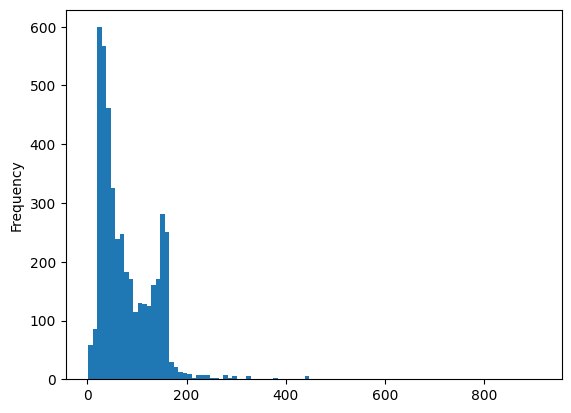

In [13]:
# plotting histogram of the messages' length
import matplotlib.pyplot as plt
spam_df['length'].plot(kind='hist', bins = 100)

In [14]:
spam_df['length'].describe()

count    4457.000000
mean       80.374018
std        60.327453
min         2.000000
25%        35.000000
50%        61.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

*Key insights from the EDA:*

- Out of the 4457 messages, 3863 are ham (87%) while 594 are spam (13%). It is highly imbalanced.
- Out of the 594 spam messages, 522 are unique, the remaining 72 are
repeated messages.
- There are no missing values.
- The shortest messages are ‘ok’ texts.
- The vast majority of the texts (over 75%) are betweeon 0 and 200 characters long.
- The longest message is 910 characters long.


#### Data Pre-Processing

In [15]:
# Changing spam/ham values to 1/0 as we will be using Logistic Regression to predict future values.
# Also, we'll get rid of the previoulsy appended 'length' column.
df = spam_df.replace('spam', 1)
df = df.replace('ham', 0)
df.drop(['length'], axis=1, inplace=True)
df

,Category,Message
0,0,"K I'm leaving soon, be there a little after 9"
1,0,No. Yes please. Been swimming?
2,0,It took Mr owl 3 licks
3,0,Its going good...no problem..but still need li...
4,0,K.. I yan jiu liao... Sat we can go 4 bugis vi...
...,...,...
4452,0,K:)k:)good:)study well.
4453,0,"Chinatown got porridge, claypot rice, yam cake..."
4454,0,"Hmm... Dunno leh, mayb a bag 4 goigng out dat ..."
4455,0,Tell me whos this pls:-)


In [16]:
df['Category'].value_counts()

0    3863
1     594
Name: Category, dtype: int64

In [17]:
# Using Count Vectorizer to transform text into numerical values.
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Message'])

In [18]:
# Visualizing some of the unique words found in all the messages.
print(vectorizer.get_feature_names_out()[0:20]) # 'head'
print(vectorizer.get_feature_names_out()[-20:-1]) # 'tail'
print(len(vectorizer.get_feature_names_out())) # There are 7718 distinct words in all our messages.

['00' '000' '000pes' '008704050406' '0089' '0121' '01223585236'
 '01223585334' '0125698789' '02' '0207' '02072069400' '02073162414'
 '02085076972' '021' '03' '04' '0430' '05' '050703']
['yoyyooo' 'yr' 'yrs' 'ystrday' 'ything' 'yummy' 'yun' 'yunny' 'yuo' 'yup'
 'zaher' 'zealand' 'zed' 'zeros' 'zhong' 'zindgi' 'zoe' 'zouk' 'zyada']
7718


In [19]:
# This matrix has 4457 rows (one for each message). In each row, a 0 means that the word in the position n from the vector built above
# is contained in the message. Conversely, a 1 means that the word in position n from the vector built above is in the message.
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [20]:
X.shape # we see 4457 messages, each with a vector of size 7718 with 0s and 1s indicating which words are contained in its message.

(4457, 7718)

In [21]:
y = df['Category']
y.shape

(4457,)

In [22]:
# Splitting the data into train and test split. Although the instructor has kept 20% of the data aside to evaluate the model,
# I will split it to validate it internally.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3565, 7718)
(892, 7718)
(3565,)
(892,)


#### Creating Logistic Regression Model

In [24]:
# defining possible parameters for Logistic Regression.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

param = {
    'penalty': ['l2'], # as requested by the instructor
    'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'C':[0.5, 1.0, 2,0, 4.0, 10.0],
    'solver':['lbfgs', 'liblinear', 'newton-cg', 'sag'],
    }

In [25]:
# Preparing to do 5-Fold Cross Validation.
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=3)

In [26]:
# Looking for the optimal model with 5-Fold Cross Validation and GridSearch.
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# defining search
search_ridge = GridSearchCV(LogisticRegression(), param, n_jobs=-1, cv=cv)
# execute search
result = search_ridge.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
480 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sk

In [27]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9813931743805516
Best Hyperparameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1}


#### Fitting LogModel

In [28]:
logmodel = LogisticRegression(penalty="l2", C=10.0, solver='lbfgs', tol=1) # Fitting model with suggested params
logmodel.fit(X_train, y_train)   # fitting model
y_hat = logmodel.predict(X_test) # predicting values

#### Testing LogModel

In [29]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_hat))

Accuracy: 0.984304932735426


In [30]:
# Check the model performance
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       777
           1       0.99      0.89      0.94       115

    accuracy                           0.98       892
   macro avg       0.99      0.94      0.96       892
weighted avg       0.98      0.98      0.98       892



<Axes: >

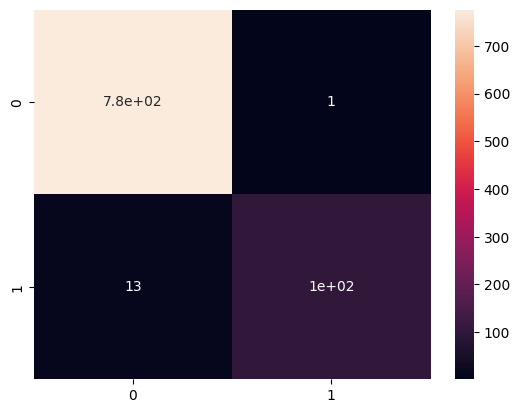

In [31]:
import seaborn as sns
%matplotlib inline
cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, annot=True)

We get very good results with the logistic regression model after doing k-cross validationa and GridSearch.

#### Creating Random Forest Classifier

In [32]:
# defining possible parameters for RFC.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

param = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1,2,3],
    'min_samples_split':[2, 4, 6]
    }

In [33]:
# Preparing to do 5-Fold Cross Validation.
cv = RepeatedKFold(n_splits=5, n_repeats=3)

In [34]:
# Looking for the optimal model with 5-Fold Cross Validation and GridSearch.
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# defining search
search_ridge = GridSearchCV(RandomForestClassifier(), param, n_jobs=-1, cv=cv)
# execute search
result = search_ridge.fit(X_train, y_train)

In [35]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8656381486676016
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 100}


#### Fitting RFC

In [36]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest classifer object
rfc = RandomForestClassifier(criterion='gini', max_depth=1, min_samples_split=2, n_estimators=100)

# Train Random Forest Classifer
rfc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred=rfc.predict(X_test)

#### Testing RFC

In [37]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8710762331838565


In [38]:
# Check the model performance
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       777
           1       0.00      0.00      0.00       115

    accuracy                           0.87       892
   macro avg       0.44      0.50      0.47       892
weighted avg       0.76      0.87      0.81       892



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

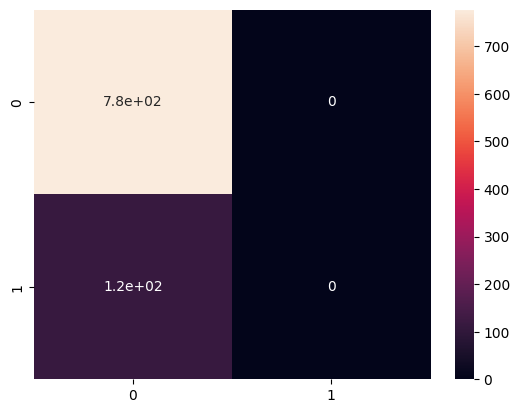

In [39]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

We can see that the model with the RFC is a lot worse. No spam was correctly identified. I am not sure why this is, as ensemble learning is much more powerful than using a single classificator.

# Question 2

The information gathered is from the DAEWOO Steel Co. Ltd in Gwangyang, South Korea. It produces several types of coils, steel plates, and iron plates. The information on electricity consumption is held in a cloud-based system. The information on energy consumption of the industry is stored on the website of the Korea Electric Power Corporation (pccs.kepco.go.kr), and the perspectives on daily, monthly, and annual data are calculated and shown.



Attribute Information:

Data Variables Type Measurement

Industry Energy Consumption Continuous kWh

Lagging Current reactive power Continuous kVarh

Leading Current reactive power Continuous kVarh

tCO2(CO2) Continuous ppm

Lagging Current power factor Continuous %

Leading Current Power factor Continuous %

Number of Seconds from midnight Continuous S

Week status Categorical (Weekend (0) or a Weekday(1))

Day of week Categorical Sunday, Monday and Saturday

Load Type Categorical Light Load, Medium Load, Maximum Load





---
### Apply Linear regression on the dataset above to build a model with Energy Consumption as the Target Variable.

### Deliverables:


1.   **Perform EDA first, delete the date column and check for nulls in the data. Also check for cross correlation among attributes. If high cross-correlation present between any attributes, append the new correlated attributes to the data as a new column (such as x1*x2, where x1 and x2 are sample attributes in the dataset). Keep the cross correlation linear and exclude polynomial attributes. [4 Marks]**

2. **Use the SGD Regressor class with scaling in your model [3 Marks].**

3. **Use repeated k cross fold with 2 repeats and k = 5. [3 Marks]**

4. **Optimize and find the optimal hyperparameters of tolerance and alpha. [3 Marks]**

5. **Use Elastic net regularization and find its optimal parameters for the model. [2 Marks]**

In [40]:
steel = pd.read_csv("Steel_industry_data.csv")

In [41]:
steel

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load


## EDA

In [42]:
# deleting date column
steel.drop(['date'], axis=1, inplace=True)

In [43]:
steel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  int64  
 7   WeekStatus                            35040 non-null  object 
 8   Day_of_week                           35040 non-null  object 
 9   Load_Type                             35040 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 2.7+ MB


In [44]:
steel.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


<Axes: >

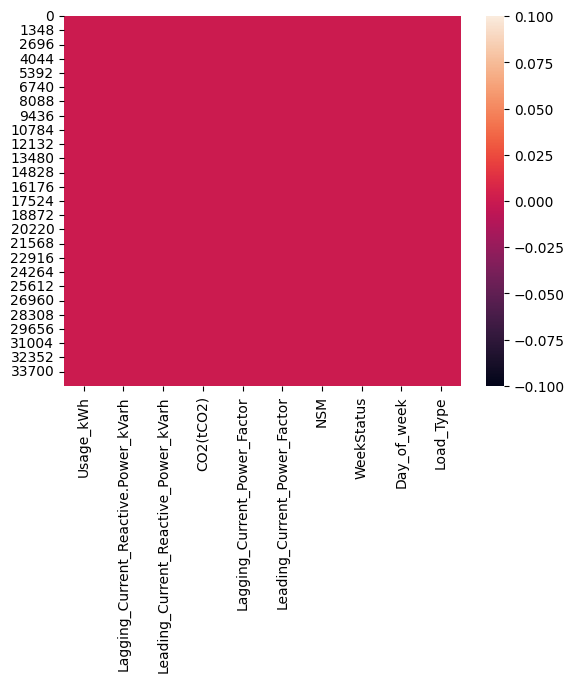

In [45]:
sns.heatmap(steel.isnull())

There are no missing values.

### Changing categorical variables to numerical

In [46]:
steel['WeekStatus'].value_counts()

Weekday    25056
Weekend     9984
Name: WeekStatus, dtype: int64

In [47]:
steel.replace({'WeekStatus' : { 'Weekday' : 0, 'Weekend':  1}},
              inplace=True)

In [48]:
steel['WeekStatus'].value_counts()

0    25056
1     9984
Name: WeekStatus, dtype: int64

In [49]:
steel['Day_of_week'].value_counts()

Monday       5088
Tuesday      4992
Wednesday    4992
Thursday     4992
Friday       4992
Saturday     4992
Sunday       4992
Name: Day_of_week, dtype: int64

In [50]:
steel.replace({'Day_of_week' : {'Monday':1, 'Tuesday': 2, 'Wednesday': 3,'Thursday': 4,'Friday': 5,'Saturday': 6,'Sunday': 7,}},
              inplace=True)

In [51]:
steel['Day_of_week'].value_counts()

1    5088
2    4992
3    4992
4    4992
5    4992
6    4992
7    4992
Name: Day_of_week, dtype: int64

In [52]:
steel['Load_Type'].value_counts()

Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: Load_Type, dtype: int64

In [53]:
steel.replace({'Load_Type' : { 'Light_Load':1, 'Medium_Load':2, 'Maximum_Load':3}},
              inplace=True)

In [54]:
steel['Load_Type'].value_counts()

1    18072
2     9696
3     7272
Name: Load_Type, dtype: int64

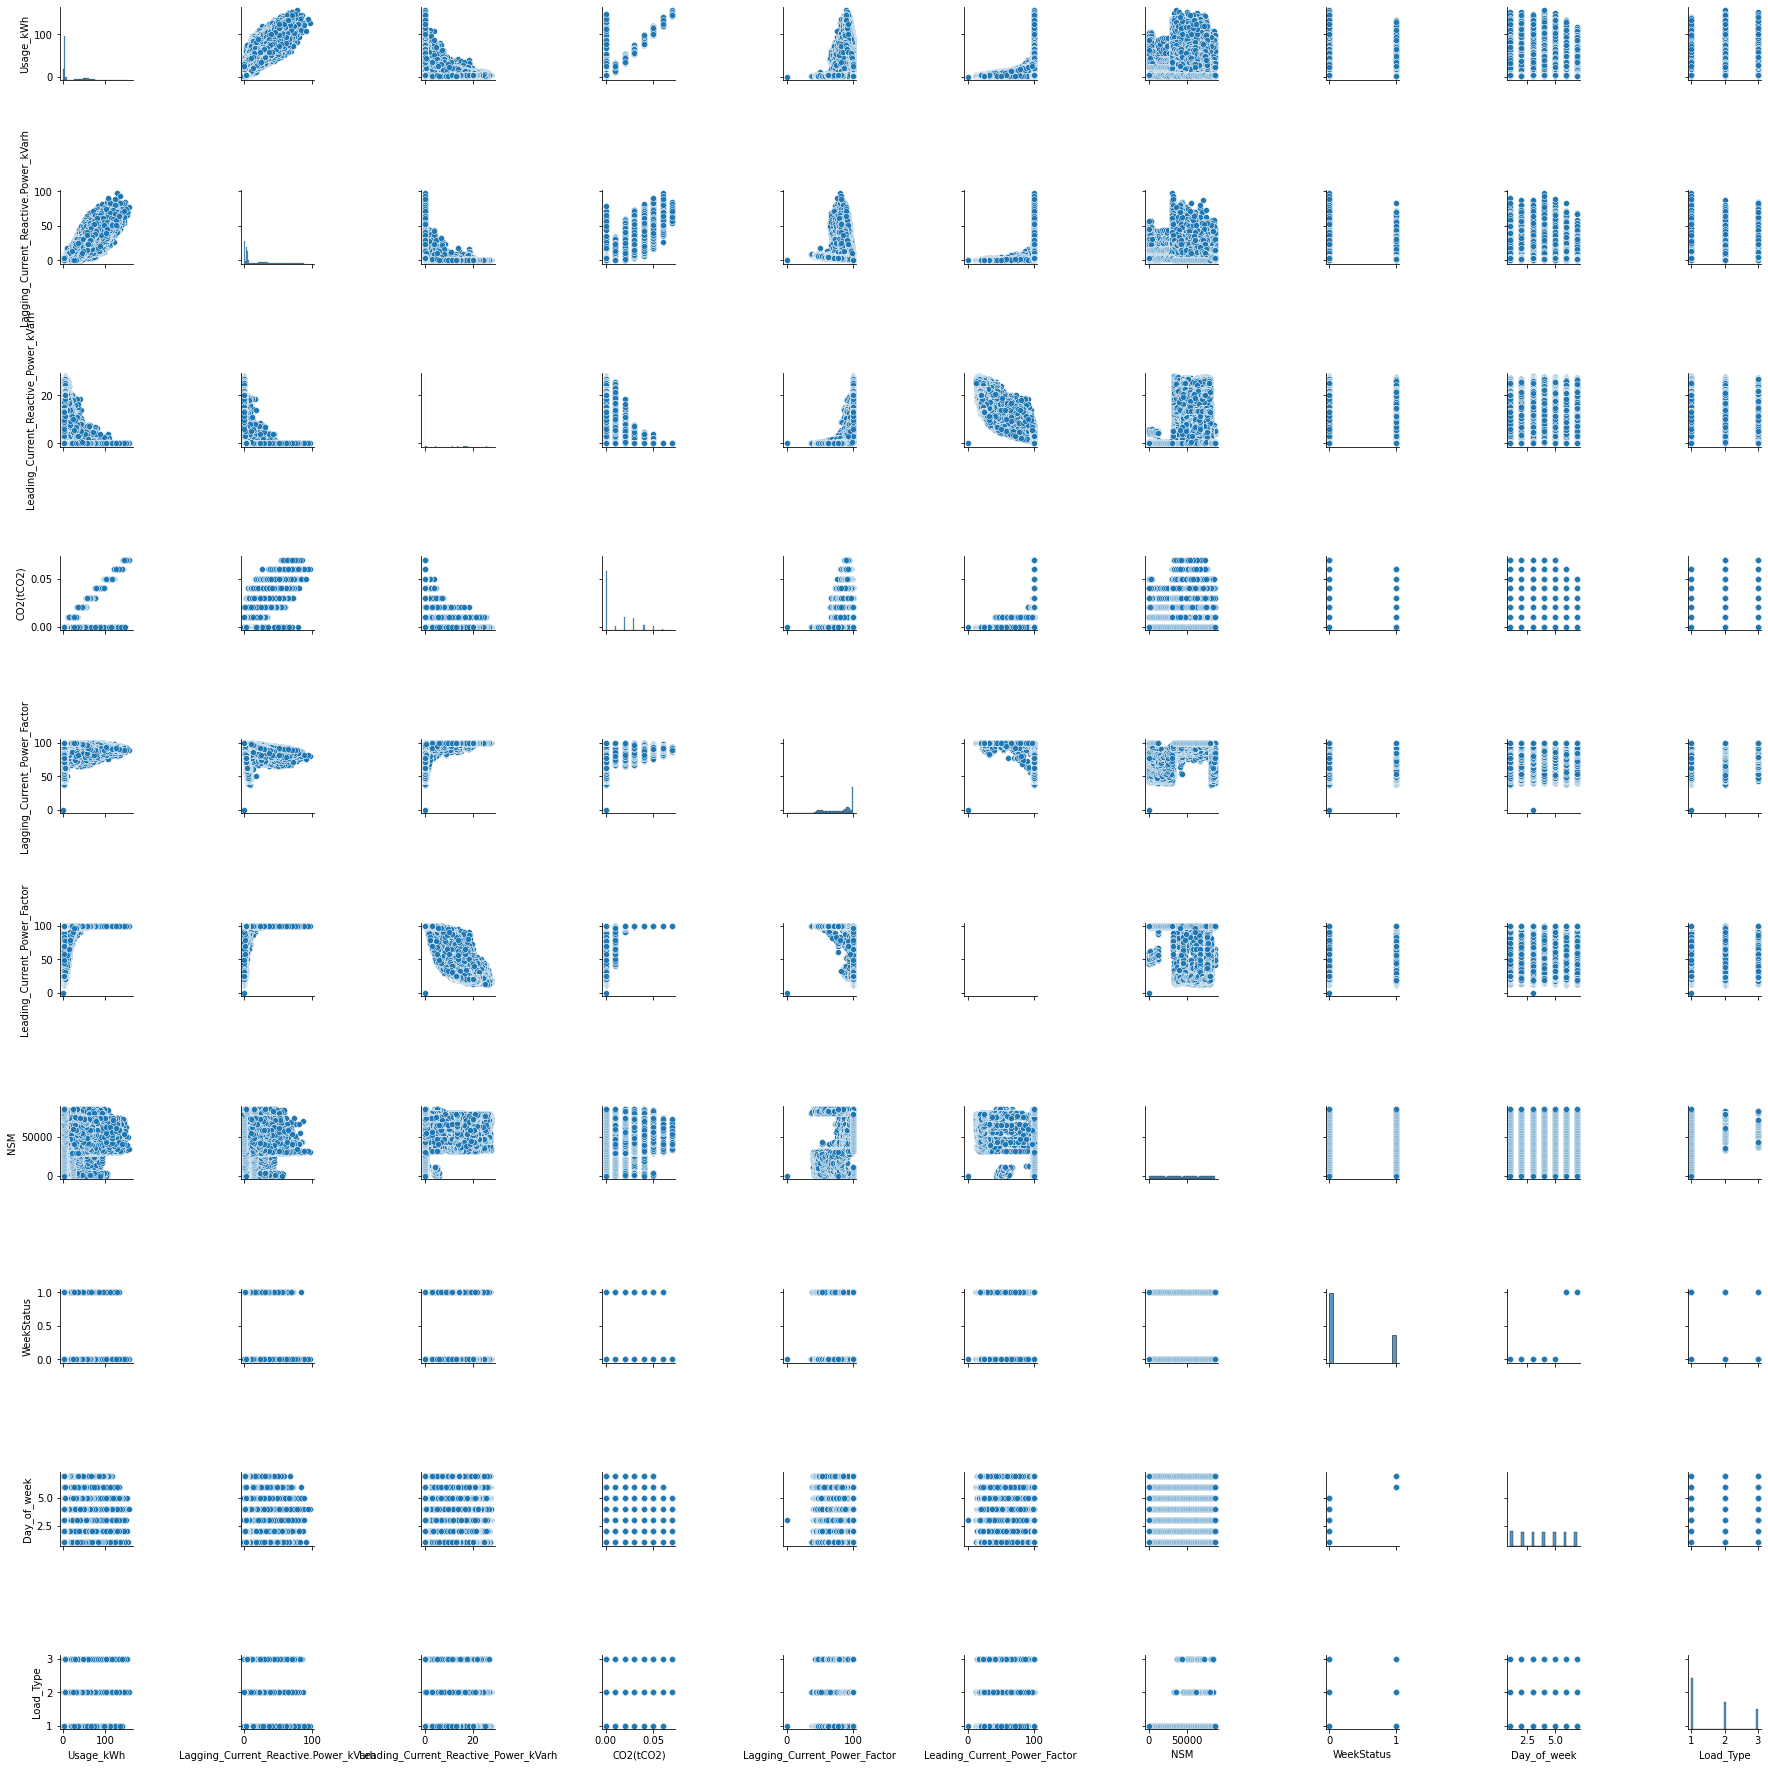

In [ ]:
sns.pairplot(steel)

In [55]:
steel.corr(method='pearson')

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
Usage_kWh,1.000000,0.896150,-0.324922,0.988180,0.385960,0.353566,2.346103e-01,-2.954748e-01,-2.407046e-01,0.614570
Lagging_Current_Reactive.Power_kVarh,0.896150,1.000000,-0.405142,0.886948,0.144534,0.407716,8.266237e-02,-3.198698e-01,-2.562275e-01,0.451899
Leading_Current_Reactive_Power_kVarh,-0.324922,-0.405142,1.000000,-0.332777,0.526770,-0.944039,3.716046e-01,2.604306e-01,2.129219e-01,0.001776
CO2(tCO2),0.988180,0.886948,-0.332777,1.000000,0.379605,0.360019,2.317260e-01,-2.904670e-01,-2.352975e-01,0.610653
Lagging_Current_Power_Factor,0.385960,0.144534,0.526770,0.379605,1.000000,-0.519967,5.652695e-01,5.408210e-02,4.246488e-02,0.519189
Leading_Current_Power_Factor,0.353566,0.407716,-0.944039,0.360019,-0.519967,1.000000,-3.605630e-01,-3.146749e-01,-2.576774e-01,0.075394
NSM,0.234610,0.082662,0.371605,0.231726,0.565270,-0.360563,1.000000e+00,-9.027984e-17,-1.011030e-16,0.482767
WeekStatus,-0.295475,-0.319870,0.260431,-0.290467,0.054082,-0.314675,-9.027984e-17,1.000000e+00,7.903022e-01,-0.199950
Day_of_week,-0.240705,-0.256227,0.212922,-0.235298,0.042465,-0.257677,-1.011030e-16,7.903022e-01,1.000000e+00,-0.168947
Load_Type,0.614570,0.451899,0.001776,0.610653,0.519189,0.075394,4.827670e-01,-1.999500e-01,-1.689472e-01,1.000000


We see the folloing correlations:

* Usage_kWh* Lagging_Current_Reactive.Power_kVarh
* Usage_kWh* CO2(tCO2)
* Lagging_Current_Reactive.Power_kVarh* CO2(tCO2)

However, because Usage_kWh is the independent variable, we will not use the combinations where it appears. We will only add the 3rd interaction and drop Lagging_Current_Reactive.Power_kVarh and CO2(tCO2) to avoid multicollinearity.


In [56]:
# adding correlated variables
steel['x2x4'] = steel['Lagging_Current_Reactive.Power_kVarh']*steel['CO2(tCO2)']
steel.drop(['Lagging_Current_Reactive.Power_kVarh'], axis=1, inplace=True)
steel.drop(['CO2(tCO2)'], axis=1, inplace=True)
steel

,Usage_kWh,Leading_Current_Reactive_Power_kVarh,Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,x2x4
0,3.17,0.00,73.21,100.00,900,0,1,1,0.0
1,4.00,0.00,66.77,100.00,1800,0,1,1,0.0
2,3.24,0.00,70.28,100.00,2700,0,1,1,0.0
3,3.31,0.00,68.09,100.00,3600,0,1,1,0.0
4,3.82,0.00,64.72,100.00,4500,0,1,1,0.0
...,...,...,...,...,...,...,...,...,...
35035,3.85,0.00,62.10,100.00,82800,0,1,1,0.0
35036,3.74,0.00,70.71,100.00,83700,0,1,1,0.0
35037,3.78,0.07,76.62,99.98,84600,0,1,1,0.0
35038,3.78,0.11,77.72,99.96,85500,0,1,1,0.0


In [57]:
y = steel['Usage_kWh']

In [58]:
X = steel.iloc[:, 1:]

## Running PCA to speed up the process

In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
X_sc.shape

(35040, 8)

In [60]:
#Splitting the data into train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.3)

In [61]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24528, 8)
(10512, 8)
(24528,)
(10512,)


In [62]:
from sklearn.decomposition import PCA
pca = PCA(0.90)
pca.fit(X_train)
print(pca.n_components_)

5


We were able to reduce the dimension from 8 to 5.

In [63]:
# transforming both train and test sets
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [64]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24528, 5)
(10512, 5)
(24528,)
(10512,)


## Creating SGD Regressor

In [65]:
# defining possible parameters for SGDRegressor.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor

param = {
    'penalty': ['elasticnet'], # as requested by the instructor
    'alpha': [1e-5, 1e-3, 1e-2, 1, 10],
    'tol':[1e-4, 1e-3, 1e-2, 0],
    }

In [66]:
# Preparing to do 5-Fold Cross Validation.
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=2)

In [67]:
# Looking for the optimal model with 5-Fold Cross Validation and GridSearch.
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor

# defining search
search = GridSearchCV(SGDRegressor(), param, n_jobs=-1, cv=cv)
# execute search
result = search.fit(X_train, y_train)

In [68]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.925546290683066
Best Hyperparameters: {'alpha': 1e-05, 'penalty': 'elasticnet', 'tol': 0.0001}


In [69]:
SGD = SGDRegressor(alpha=0.00001, penalty="elasticnet", tol=0.0001) # Fitting model with suggested params
SGD.fit(X_train, y_train)   # fitting model
y_hat = SGD.predict(X_test) # predicting values

## Testing SGD Model

In [70]:
from sklearn import metrics
from sklearn.metrics import r2_score
print("\tExplained variance:", metrics.explained_variance_score(y_test, y_hat))
print("\tMean absolute error:", metrics.mean_absolute_error(y_test, y_hat))
print("\tR2 score:", r2_score(y_test, y_hat))

	Explained variance: 0.9270705883762256
	Mean absolute error: 6.153934039401261
	R2 score: 0.927035927761256
